˙ 모델 투입 전 이미지를 불러오는 방식에 npy 파일 형식 활용</br>
해당 파일은 npy를 save하는 방식은 다루고 있지 않습니다
=> FYI :: 이미지를 불러오는 방식에 flow_from_directory라는 다른 메소드도 있는데요, 이 방법의 경우 폴더 형태의 데이터 구조를 바로 가져와서 사용할 수 있다는 장점이 있습니다만 이미지 데이터 동기화의 효율성이 너무 떨어져서 배제하겠습니다.

In [0]:
%tensorflow_version 1.x

In [3]:
# 1. 모듈 import
import os, numpy as np
from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
import matplotlib.pyplot as plt
from keras.callbacks import ModelCheckpoint, EarlyStopping

Using TensorFlow backend.


In [8]:
# 2. npy 데이터를 불러와서 모델 학습
X_train, X_test, y_train, y_test = np.load("/content/drive/My Drive/test_data_after.npy", allow_pickle=True)
print(f'X_train: {X_train.shape}, y_train: {y_train.shape}')  
print(f'X_test: {X_test.shape}, y_test: {y_test.shape}') 


X_train: (15916, 64, 64, 3), y_train: (15916, 5)
X_test: (3980, 64, 64, 3), y_test: (3980, 5)


In [12]:
# 정규화 불필요, 초반 X, y로 분리 작업 때 아예 정규화시키는 기능 추가
# 3. 검증 세트(val set) 준비 (X_train의 20%, 3183개를 따로 분리)
X_val = X_train[:3183]
X_train = X_train[3183:]
y_val = y_train[:3183]
y_train = y_train[3183:]
print(f'X_val : {X_val.shape}, X_train : {X_train.shape}')
print(f'y_val : {y_val.shape}, y_train : {y_train.shape}')

X_val : (3183, 64, 64, 3), X_train : (12733, 64, 64, 3)
y_val : (3183, 5), y_train : (12733, 5)


In [34]:
# 4. CNN 모델 구성
model = Sequential()
model.add(Conv2D(32, kernel_size=(4, 4), strides=(1, 1), padding='same', activation='relu', input_shape=(64, 64, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(5, activation='softmax'))
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 64, 64, 32)        1568      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 16, 16, 32)        9248      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 8, 8, 32)          0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 8, 8, 32)         

In [10]:
# 4. 모델 컴파일
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [13]:
# 5. 모델 학습
model_dir = "./model"
if not os.path.exists(model_dir):
  os.mkdir(model_dir)
model_path = model_dir + '/test.model'
checkpoint = ModelCheckpoint(filepath=model_path, monitor='val_loss', verbose=1, save_best_only=True)
early_stopping = EarlyStopping(monitor='val_loss', patience=5)
hist = model.fit(X_train, y_train, epochs=150, batch_size=100, validation_data=(X_val, y_val), callbacks=[checkpoint, early_stopping])


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Train on 12733 samples, validate on 3183 samples
Epoch 1/150





12733/12733 [==============================] - 17s 1ms/step - loss: 1.0702 - acc: 0.4941 - val_loss: 0.7863 - val_acc: 0.6349

Epoch 00001: val_loss improved from inf to 0.78628, saving model to ./model/test.model
Epoch 2/150
12733/12733 [==============================] - 2s 159us/step - loss: 0.7440 - acc: 0.6851 - val_loss: 0.5689 - val_acc: 0.7892

Epoch 00002: val_loss improved from 0.78628 to 0.56895, saving model to ./model/test.model
Epoch 3/150
12733/12733 [==============================] - 2s 159us/step - loss: 0.5815 - acc: 0.7683 - val_loss: 0.5059 - val_acc: 0.8027

Epoch 00003: val_loss improved from 0.56895 to 0.50594, saving model to ./model/test.model
Epoch 4/150
12733/12733 [==============================] - 2s 157us/step - loss: 0.5045 - acc: 0.8055 - val_loss: 0.4168 - val_acc: 0.8495

Epoch 00004: val_loss

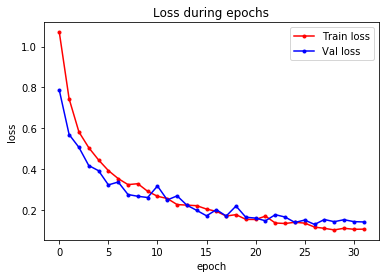

In [26]:
# loss 그래프
train_loss = hist.history['loss']
val_loss = hist.history['val_loss']

x = range(len(train_loss))
plt.plot(x, train_loss, marker='.', color='red', label='Train loss')
plt.plot(x, val_loss, marker='.', color='blue', label='Val loss')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Loss during epochs')
plt.show()

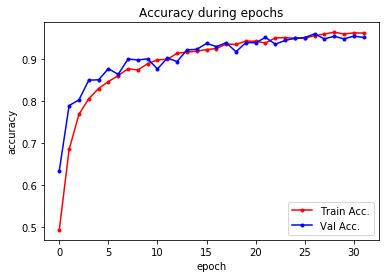

In [28]:
# acc 그래프
train_acc = hist.history['acc']
val_acc = hist.history['val_acc']

plt.plot(x, train_acc, marker='.', c='red', label='Train Acc.')
plt.plot(x, val_acc, marker='.', c='blue', label='Val Acc.')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Accuracy during epochs')
plt.show()


In [29]:
# Test set으로 모델 평가
score = model.evaluate(X_test, y_test, verbose=0)
print('Training loss:', score[0])
print('Training accuracy: ', score[1])

Training loss: 0.13078376159034483
Training accuracy:  0.9510050251855323


In [0]:
# 모델 저장하기
from keras.models import load_model
model.save('cnn_model1st.h5')

In [32]:
# Confusion Matrix

from sklearn.metrics import confusion_matrix, classification_report
test_true = np.argmax(y_test, axis=1)
print(test_true)
test_pred = np.argmax(model.predict(X_test), axis=1)
print(test_pred)

cm = confusion_matrix(test_true, test_pred)
print(cm)

[2 0 1 ... 2 2 4]
[2 0 1 ... 2 2 4]
[[640   0  37  15   0]
 [  0 860   3   1   7]
 [  9   0 764  42   0]
 [  2   0  52 700   1]
 [  0  15   1  10 821]]


In [33]:
# Classification Report
from sklearn.metrics import classification_report
report = classification_report(test_true, test_pred)
print(report)

              precision    recall  f1-score   support

           0       0.98      0.92      0.95       692
           1       0.98      0.99      0.99       871
           2       0.89      0.94      0.91       815
           3       0.91      0.93      0.92       755
           4       0.99      0.97      0.98       847

    accuracy                           0.95      3980
   macro avg       0.95      0.95      0.95      3980
weighted avg       0.95      0.95      0.95      3980

